# **Covid19 in Ireland analysis**

# Importing modules and data

In [ ]:
# importing our main modules
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns
from collections import Counter

In [ ]:
# fetching our daily covid dataset (updated daily at 6pm)
covid_ie = 'http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}'
covid_counties = 'http://opendata-geohive.hub.arcgis.com/datasets/4779c505c43c40da9101ce53f34bb923_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}'
df = pd.read_csv(covid_ie)
df_county = pd.read_csv(covid_counties)

In [ ]:
# this will be our daily rain and temperature data source for Dublin
# https://www.met.ie/climate/available-data/historical-data


# Cleaning our data, defining some useful functions

In [ ]:
#@title right now, our main dataframe looks like this
df.head(2)

,X,Y,Date,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,StatisticsProfileDate,CovidCasesConfirmed,HospitalisedCovidCases,RequiringICUCovidCases,HealthcareWorkersCovidCases,ClustersNotified,HospitalisedAged5,HospitalisedAged5to14,HospitalisedAged15to24,HospitalisedAged25to34,HospitalisedAged35to44,HospitalisedAged45to54,HospitalisedAged55to64,HospitalisedAged65up,Male,Female,Unknown,Aged1,Aged1to4,Aged5to14,Aged15to24,Aged25to34,Aged35to44,Aged45to54,Aged55to64,Aged65up,Median_Age,CommunityTransmission,CloseContact,TravelAbroad,FID
0,-856335.869598,7.036492e+06,2020/02/29 00:00:00+00,1,1,0,0,2020/02/27 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,-856335.869598,7.036492e+06,2020/03/03 00:00:00+00,1,2,0,0,2020/03/01 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
#@title and that's what the county level one looks like
df_county.sample(2)

,ORIGID,CountyName,PopulationCensus16,IGEasting,IGNorthing,Lat,Long,UniqueGeographicIdentifier,ConfirmedCovidCases,PopulationProportionCovidCases,ConfirmedCovidDeaths,ConfirmedCovidRecovered,x,y,FID,TimeStampDate
10,NaN,Laois,84697,244211,193996,52.9952,-7.3423,http://data.geohive.ie/resource/county/2ae1962...,525,619.856666,NaN,NaN,-7.3423,52.9952,5757,2020/10/07 00:00:00+00
6,NaN,Galway,258058,151045,235818,53.3705,-8.7362,http://data.geohive.ie/resource/county/2ae1962...,931,360.771609,NaN,NaN,-8.7362,53.3705,5753,2020/10/07 00:00:00+00


In [ ]:
# let's drop those 2 useless first series for our df dataframe
df = df.drop(['X', 'Y'], axis=1)

# same for the ORIGID series for our df_county dataframe as it's full of NULL values anyway
df_county = df_county.drop(['ORIGID'], axis=1)

In [ ]:
# now let's clean up the Date serie, removing the hours/mins/secs
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [ ]:
# adding in a new serie for months only
df['Month'] = pd.to_datetime(df['Date']).dt.to_period('M')

# grouping cases and deaths by month
grouped_by = df.groupby('Month', as_index=False).agg({'ConfirmedCovidCases': 'sum', 'ConfirmedCovidDeaths': 'sum'})

In [ ]:
# defining our matplotlib RcParams, optional but makes the plots look better
rc = {
      'figure.figsize': (19,5),
      'axes.facecolor': 'white',
      'axes.grid': False,
      'axes.edgecolor': 'white',
      'grid.color': 'white',
      'font.family': 'monospace',
      'font.size': 15
       }
plt.rcParams.update(rc)

# setting colors
barplots_colors = 'rocket'
histplots_colors = 'green'

In [ ]:
# building a side by side bar plot on Seaborn
def make_twobarcharts(x1,y1,x2,y2,title1,title2,xorient):
  fig = plt.figure()
  plt.subplot(121)
  left = sns.barplot(x=x1, y=y1, orient='v', palette=barplots_colors)
  sns.despine(left=True, right=True, top=True, bottom=True)
  plt.xticks(rotation=xorient)
  plt.xlabel('')
  plt.ylabel('')
  left.set_title(title1)
  plt.subplot(122)
  right = sns.barplot(x=x2, y=y2, orient='v', palette=barplots_colors)
  sns.despine(left=True, right=True, top=True, bottom=True)
  plt.xticks(rotation=xorient)
  plt.xlabel('')
  plt.ylabel('')
  right.set_title(title2)
  plt.subplots_adjust(wspace = 0.2, hspace = 0.4, top = 0.9)
  plt.show()

# Dataframe sample

In [ ]:
#@title Ireland level dataframe
df.tail(3)

,Date,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,StatisticsProfileDate,CovidCasesConfirmed,HospitalisedCovidCases,RequiringICUCovidCases,HealthcareWorkersCovidCases,ClustersNotified,HospitalisedAged5,HospitalisedAged5to14,HospitalisedAged15to24,HospitalisedAged25to34,HospitalisedAged35to44,HospitalisedAged45to54,HospitalisedAged55to64,HospitalisedAged65up,Male,Female,Unknown,Aged1,Aged1to4,Aged5to14,Aged15to24,Aged25to34,Aged35to44,Aged45to54,Aged55to64,Aged65up,Median_Age,CommunityTransmission,CloseContact,TravelAbroad,FID,Month
219,2020-10-07,611,39584,5,1816,2020/10/05 00:00:00+00,38973.0,3701.0,478.0,9434.0,4554.0,34.0,27.0,102.0,223.0,300.0,496.0,559.0,1959.0,17670.0,21265.0,38.0,223.0,383.0,1353.0,5030.0,6847.0,6574.0,6418.0,4498.0,7623.0,43.0,28.0,68.0,2.0,220,2020-10
220,2020-10-08,506,40086,1,1817,2020/10/06 00:00:00+00,39580.0,3729.0,482.0,9490.0,4651.0,35.0,27.0,105.0,227.0,303.0,499.0,562.0,1970.0,17972.0,21568.0,40.0,229.0,395.0,1393.0,5181.0,6938.0,6633.0,6489.0,4575.0,7723.0,43.0,28.0,68.0,2.0,221,2020-10
221,2020-10-09,617,40703,5,1821,2020/10/07 00:00:00+00,40086.0,3755.0,484.0,9536.0,4795.0,35.0,29.0,105.0,229.0,305.0,499.0,568.0,1984.0,18212.0,21833.0,41.0,234.0,402.0,1418.0,5331.0,7016.0,6694.0,6560.0,4624.0,7783.0,43.0,28.0,68.0,2.0,222,2020-10


In [ ]:
#@title County level dataframe
df_county.sample(3)

,CountyName,PopulationCensus16,IGEasting,IGNorthing,Lat,Long,UniqueGeographicIdentifier,ConfirmedCovidCases,PopulationProportionCovidCases,ConfirmedCovidDeaths,ConfirmedCovidRecovered,x,y,FID,TimeStampDate
14,Louth,128884,299463,297349,53.9161,-6.4870,http://data.geohive.ie/resource/county/2ae1962...,1111,862.015456,NaN,NaN,-6.4870,53.9161,5761,2020/10/07 00:00:00+00
4,Donegal,159192,202615,405691,54.8989,-7.9600,http://data.geohive.ie/resource/county/2ae1962...,1299,815.995779,NaN,NaN,-7.9600,54.8989,5751,2020/10/07 00:00:00+00
17,Monaghan,61386,268914,326818,54.1857,-6.9452,http://data.geohive.ie/resource/county/2ae1962...,777,1265.760923,NaN,NaN,-6.9452,54.1857,5764,2020/10/07 00:00:00+00


# Visualisation - Seaborn

In [ ]:
#@title Non plottable data
male, female = df.Male.max(), df.Female.max()
perc1, perc2 = (female / (male + female)) * 100, (male / (male + female)) * 100

print('The total number of Covid cases is:', df.TotalConfirmedCovidCases.max())
print('The total number of Covid deaths is:', df.TotalCovidDeaths.max())
print('The median age is:', round(df.Median_Age.mean(), 1))
print('The ratio female / male is: ', round(perc1, 1), 'female,', round(perc2, 1), 'male')

The total number of Covid cases is: 40703
The total number of Covid deaths is: 1821
The median age is: 47.1
The ratio female / male is:  54.5 female, 45.5 male


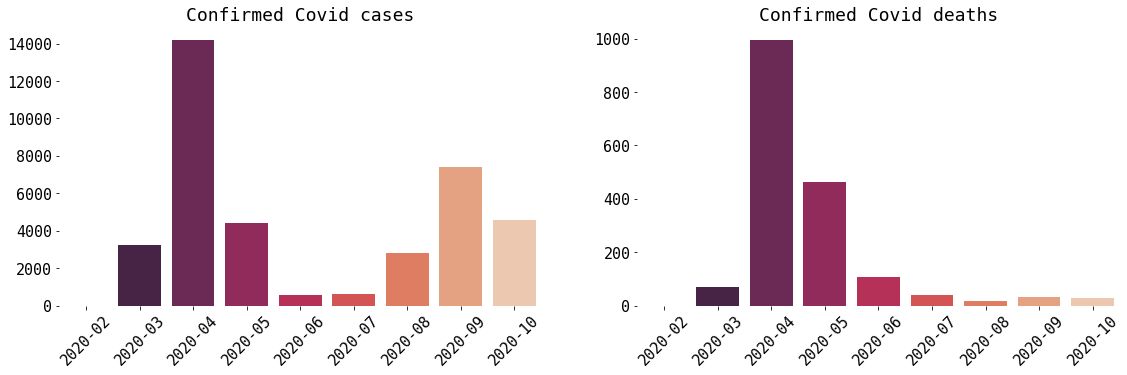

In [ ]:
#@title
# setting values
x1,y1 = grouped_by.Month, grouped_by.ConfirmedCovidCases
x2,y2 = grouped_by.Month, grouped_by.ConfirmedCovidDeaths
title1,title2 = 'Confirmed Covid cases', 'Confirmed Covid deaths'

# calling our double bar chart function
make_twobarcharts(x1,y1,x2,y2,title1,title2,45)

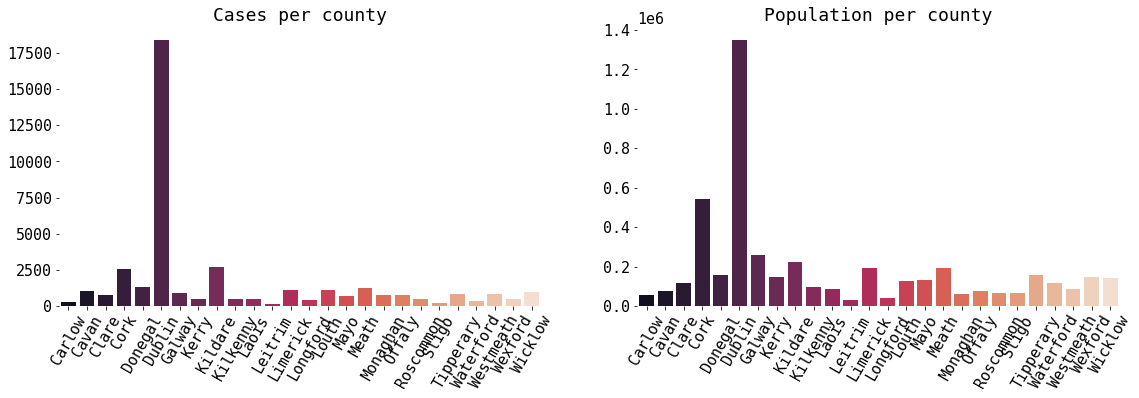

In [ ]:
#@title
# setting values
x1,y1 = df_county.CountyName, df_county.ConfirmedCovidCases
x2,y2 = df_county.CountyName, df_county.PopulationCensus16
title1,title2 = 'Cases per county', 'Population per county'

# calling our double bar chart function
make_twobarcharts(x1,y1,x2,y2,title1,title2,60)

# Alternative visualization - Altair

In [ ]:
#@title
alt.Chart(df).mark_bar().encode(
    x = alt.X('Date:T'),
    y = alt.Y('ConfirmedCovidCases:Q'),
    color=alt.Color('ConfirmedCovidDeaths:Q', scale=alt.Scale(scheme='goldred')),  
    tooltip = [alt.Tooltip('ConfirmedCovidCases'),
               alt.Tooltip('ConfirmedCovidDeaths'),
               alt.Tooltip('Male'),
               alt.Tooltip('Female')]
).properties(
    width=700,
    height=250
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).interactive()

alt.Chart(...)

In [ ]:
#@title
alt.Chart(df_county).mark_bar().encode(
    x = 'CountyName:N',
    y = 'PopulationCensus16:Q',
    color=alt.Color('ConfirmedCovidCases:Q', scale=alt.Scale(scheme='goldred'))    
).properties(
    width=700,
    height=250
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).interactive()

alt.Chart(...)

In [ ]:
#@title
alt.Chart(df).mark_bar().encode(
    x = alt.X('Date:T'),
    y = alt.Y('HospitalisedCovidCases:Q'),
    color=alt.Color('CovidCasesConfirmed:Q', scale=alt.Scale(scheme='goldred'))    
).properties(
    width=700,
    height=250
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).interactive()

alt.Chart(...)

In [ ]:
#@title
alt.Chart(df_county).mark_bar().encode(
    x = alt.X('TimeStamp:T'),
    y = alt.Y('ConfirmedCovidCases:Q', scale=alt.Scale(domain=(0, 25000))),
    color=alt.Color('CountyName:N', scale=alt.Scale(scheme='goldred'))
).properties(
    width=700,
    height=250
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).interactive()

alt.Chart(...)